In [1]:
import pandas as pd

# Load the dataset using ISO-8859-1 encoding
df = pd.read_csv("data.csv", encoding='ISO-8859-1')

# Display basic info
print(df.info())
print(df.head())

C:\Users\91911\AppData\Local\Temp\ipykernel_3784\3567615493.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding='ISO-8859-1')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  object 
dtyp

In [2]:
# Drop rows where critical fields are missing
df_cleaned = df.dropna(subset=['state', 'location', 'date'])

# Fill missing numeric values with the column mean
num_cols = ['so2', 'no2', 'rspm', 'spm', 'pm2_5']
df_cleaned[num_cols] = df_cleaned[num_cols].fillna(df_cleaned[num_cols].mean())

# Fill missing categorical values with the mode
cat_cols = ['agency', 'type', 'location_monitoring_station']
for col in cat_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# Standardize column names
df_cleaned.columns = [col.lower().strip().replace(" ", "_") for col in df_cleaned.columns]


C:\Users\91911\AppData\Local\Temp\ipykernel_3784\1691459151.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[num_cols] = df_cleaned[num_cols].fillna(df_cleaned[num_cols].mean())
C:\Users\91911\AppData\Local\Temp\ipykernel_3784\1691459151.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])


In [3]:
# Simulate a dataset of state codes
state_codes = pd.DataFrame({
    'state': df_cleaned['state'].unique(),
    'state_code': range(1, len(df_cleaned['state'].unique()) + 1)
})

# Merge on 'state'
df_merged = pd.merge(df_cleaned, state_codes, on='state', how='left')


In [4]:
# Convert 'date' to datetime
df_merged['date'] = pd.to_datetime(df_merged['date'], errors='coerce')

# Extract year and month
df_merged['year'] = df_merged['date'].dt.year
df_merged['month'] = df_merged['date'].dt.month

# Create a simplified pollution index
df_merged['pollution_index'] = df_merged[['so2', 'no2', 'rspm']].mean(axis=1)


In [5]:
# Convert negative values to positive in pollution columns
for col in ['so2', 'no2', 'rspm', 'spm', 'pm2_5']:
    df_merged[col] = df_merged[col].apply(lambda x: abs(x) if pd.notnull(x) else x)

# Capitalize the pollution type field for consistency
df_merged['type'] = df_merged['type'].str.title()


In [6]:
# View the first 10 rows of the final dataset
print(df_merged.head(10))

# Check summary statistics
print(df_merged.describe(include='all'))

# Check if there are still any missing values
print(df_merged.isnull().sum())


  stn_code       sampling_date           state   location  \
0    150.0  February - M021990  Andhra Pradesh  Hyderabad   
1    151.0  February - M021990  Andhra Pradesh  Hyderabad   
2    152.0  February - M021990  Andhra Pradesh  Hyderabad   
3    150.0     March - M031990  Andhra Pradesh  Hyderabad   
4    151.0     March - M031990  Andhra Pradesh  Hyderabad   
5    152.0     March - M031990  Andhra Pradesh  Hyderabad   
6    150.0     April - M041990  Andhra Pradesh  Hyderabad   
7    151.0     April - M041990  Andhra Pradesh  Hyderabad   
8    152.0     April - M041990  Andhra Pradesh  Hyderabad   
9    151.0       May - M051990  Andhra Pradesh  Hyderabad   

                                      agency  \
0  Maharashtra State Pollution Control Board   
1  Maharashtra State Pollution Control Board   
2  Maharashtra State Pollution Control Board   
3  Maharashtra State Pollution Control Board   
4  Maharashtra State Pollution Control Board   
5  Maharashtra State Pollution Control B

In [7]:
# Check original vs final shape
print("Original shape:", df.shape)
print("Final shape after cleaning:", df_merged.shape)

# Compare columns
print("Original columns:", df.columns.tolist())
print("Final columns:", df_merged.columns.tolist())


Original shape: (435742, 13)
Final shape after cleaning: (435735, 17)
Original columns: ['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5', 'date']
Final columns: ['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5', 'date', 'state_code', 'year', 'month', 'pollution_index']


In [8]:
df_merged.to_csv("cleaned_air_quality_data.csv", index=False)


<Axes: title={'center': 'Average Pollution Index by Year'}, xlabel='year'>

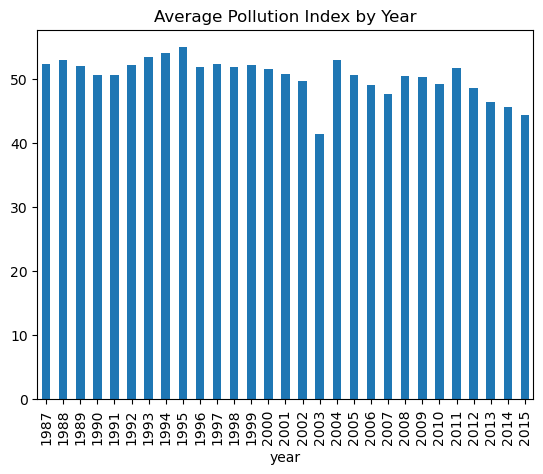

In [9]:
df_merged.groupby("year")["pollution_index"].mean().plot(kind='bar', title="Average Pollution Index by Year")
